In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(color_codes=True)

## Import dataset

In [2]:
data = pd.read_csv('1979-2021.csv', index_col='Date', parse_dates=['Date'], dayfirst=True)
df = data.iloc[:, 1:2]
df.head()

,Europe(EUR)
Date,
1979-01-31,144.8
1979-02-28,154.6
1979-03-30,148.0
1979-04-30,152.8
1979-05-31,172.0


<AxesSubplot:xlabel='Date'>

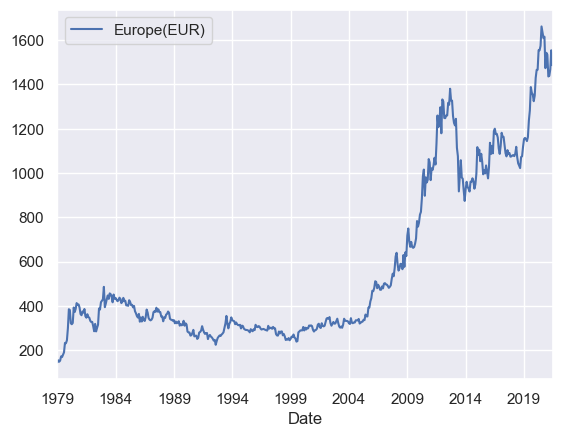

In [3]:
df.plot()

## Normalize the Data and Train Test Split 

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [5]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

In [6]:
ts_train, ts_test = train_test_split(df_scaled, test_size=0.2, shuffle=False, random_state=42)
ts_train.shape, ts_test.shape

((408, 1), (103, 1))

## Create sequences for LSTM

In [7]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    
    Xi, y = np.array(x), np.array(y)
    X = np.reshape(Xi, (Xi.shape[0], Xi.shape[1], 1))
    return X, y

sequence_length = 10

X_train, y_train = create_sequences(ts_train, sequence_length)
X_test, y_test = create_sequences(ts_test, sequence_length)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((398, 10, 1), (93, 10, 1), (398,), (93,))

## Build and Train the LSTM model

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [11]:
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5', 
                                      save_best_only=True,
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      mode='auto',
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_accuracy',
                                       patience=3,  
                                       mode='auto',
                                       verbose=1,
                                       restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size= 32,
                    epochs= 10, 
                    validation_split=.1,
                    verbose=1,
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10


 8/12 [===================>..........] - ETA: 0s - loss: 0.0068 - accuracy: 0.0000e+00 
Epoch 1: val_loss improved from inf to 0.03926, saving model to model_checkpoint.h5
12/12 [==============================] - 3s 60ms/step - loss: 0.0060 - accuracy: 0.0000e+00 - val_loss: 0.0393 - val_accuracy: 0.0000e+00
Epoch 2/10
 9/12 [=====================>........] - ETA: 0s - loss: 0.0017 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.03926
12/12 [==============================] - 0s 9ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 0.0602 - val_accuracy: 0.0000e+00
Epoch 3/10
10/12 [========================>.....] - ETA: 0s - loss: 0.0011 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 0.03926 to 0.02267, saving model to model_checkpoint.h5
12/12 [==============================] - 0s 10ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 0.0227 - val_accuracy: 0.0000e+00
Epoch 4/10
10/12 [========================>.....] - ETA: 0s - loss: 7.2

In [12]:
score = model.evaluate(X_test, y_test, batch_size=64)

2/2 [==============================] - 0s 4ms/step - loss: 0.0416 - accuracy: 0.0108


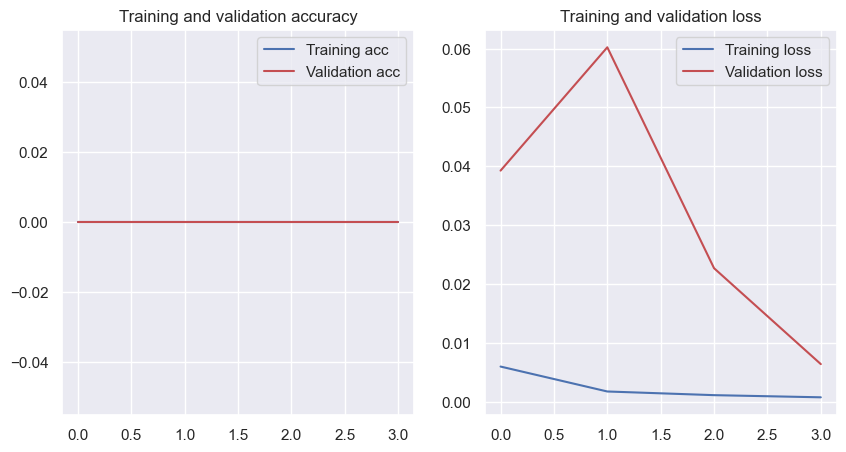

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## Visualize the Actual and Predicted Close Price

In [14]:
var = 'Europe(EUR)'

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

3/3 [==============================] - 0s 7ms/step


In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score

In [16]:
def evaluation(y_test, y_pred):
    print('Coeficient of determination: %.2f'% r2_score(y_test, y_pred))
    print('Mean squared error         : %.2f'% mean_squared_error(y_test, y_pred))
    print('Root mean squared error    : %.2f'% np.sqrt(mean_squared_error(y_test, y_pred)))
    print('Explained variance score   : %.2f'% explained_variance_score(y_test, y_pred))
    print('Mean absolute error        : %.2f'% mean_absolute_error(y_test, y_pred))

In [17]:
evaluation(df[-len(predictions):][var], predictions)

Coeficient of determination: -1.28
Mean squared error         : 95707.20
Root mean squared error    : 309.37
Explained variance score   : 0.68
Mean absolute error        : 286.60


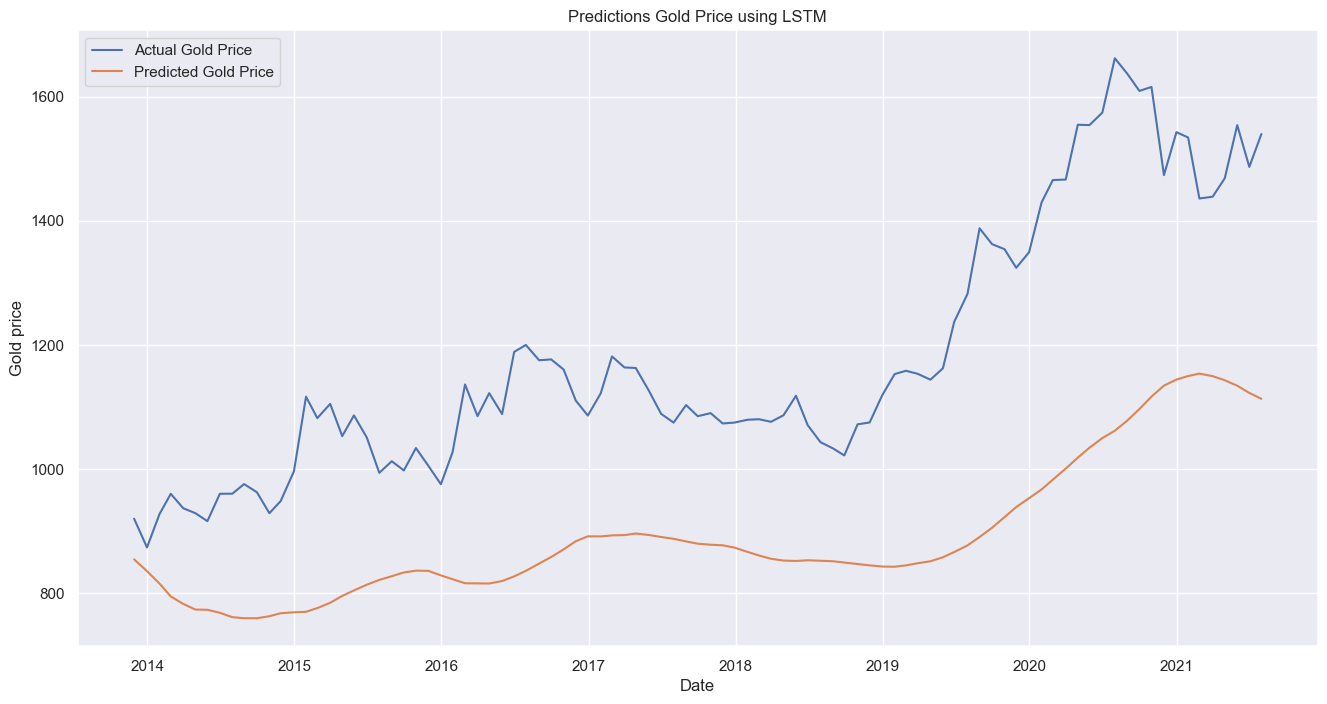

In [18]:
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(predictions):], df[-len(predictions):][var], label='Actual Gold Price')
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Gold Price')
plt.title('Predictions Gold Price using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()

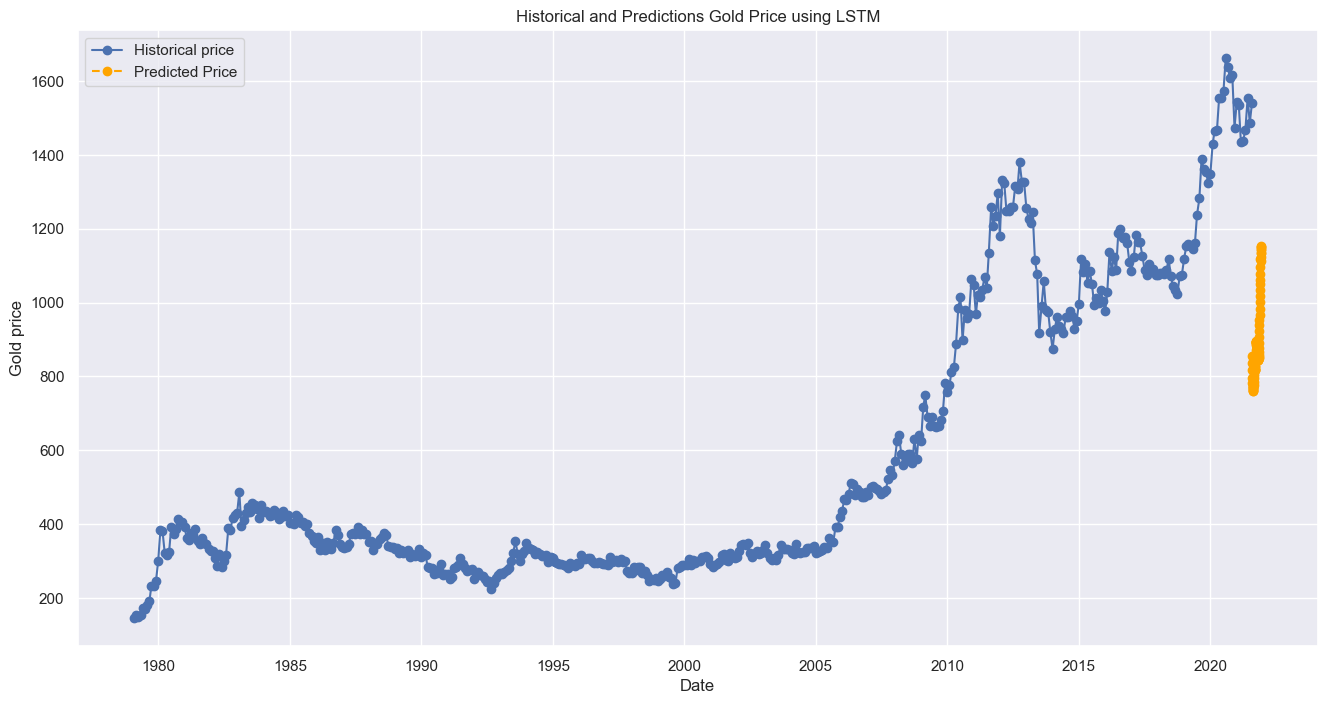

In [19]:
plt.figure(figsize=(16,8))
plt.plot(df.index, df[var], label='Historical price', marker='o', linestyle='-', color='b')

pred_dates = pd.date_range(start=df.index[-1], periods=len(predictions)+1, freq='B')[1:]
plt.plot(pred_dates, predictions, label='Predicted Price', linestyle='dashed', color='orange',marker='o')

plt.title('Historical and Predictions Gold Price using LSTM')
plt.xlabel('Date')
plt.ylabel('Gold price')
plt.legend()
plt.show()